In [1]:
#import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings
from pylab import rcParams
from datetime import datetime


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
#create a path
path = r"C:\Users\jacob\Documents\Data Analytics\Data Immersion\Achievement 6\Energy_GDP_Project"

In [3]:
# Import data
data = pd.read_csv(os.path.join(path, '02 data', 'prepared data', 'energy_gdp_merged_inner_countries.csv'))

In [4]:
#check output
data.head()

,country,year,combined_key,ea_%_pop,%_energy_nuclear,%_energy_renewables,%_energy_fossil_fuels,gdp
0,Afghanistan,2000,"Afghanistan, 2000",4.446891,0.0,0.0,0.0,183.532775
1,Afghanistan,2001,"Afghanistan, 2001",9.294527,0.0,0.0,0.0,183.532775
2,Afghanistan,2002,"Afghanistan, 2002",14.133616,0.0,0.0,0.0,183.532775
3,Afghanistan,2003,"Afghanistan, 2003",18.971165,0.0,0.0,0.0,200.462376
4,Afghanistan,2004,"Afghanistan, 2004",23.814182,0.0,0.0,0.0,221.657662


In [5]:
#clean data frame
data.drop(columns = ['combined_key'], inplace = True)
data.rename(columns = {'ea_%_pop' : '%_ea', '%_energy_nuclear' :' %_nuclear', '%_energy_renewables' : '%_renew', '%_energy_fossil_fuels': '%_fossil_fuels', 'gdp' : 'gdp_per_capita'}, inplace = True)

In [6]:
#check cleaning
data.head()

,country,year,%_ea,%_nuclear,%_renew,%_fossil_fuels,gdp_per_capita
0,Afghanistan,2000,4.446891,0.0,0.0,0.0,183.532775
1,Afghanistan,2001,9.294527,0.0,0.0,0.0,183.532775
2,Afghanistan,2002,14.133616,0.0,0.0,0.0,183.532775
3,Afghanistan,2003,18.971165,0.0,0.0,0.0,200.462376
4,Afghanistan,2004,23.814182,0.0,0.0,0.0,221.657662


In [7]:
#check data shape
data.shape

(4730, 7)

In [8]:
#check data columns
data.columns

Index(['country', 'year', '%_ea', ' %_nuclear', '%_renew', '%_fossil_fuels',
       'gdp_per_capita'],
      dtype='object')

In [9]:
#create a subset of the data that only contains the colunns for country year and gpd per capita
data_plot = data[['country','year', 'gdp_per_capita']]

In [10]:
#create a subset of the data that only look at GDP per capita for the world data only
data_world_plot = data_plot.loc[data['country'] == 'World']

In [11]:
#create a datetime column from the year column and then turn datetime into the index
data_world_plot['datetime'] = pd.to_datetime(data_world_plot['year'], format='%Y')
data_world_plot = data_world_plot.set_index('datetime')

In [12]:
#drop the year column and check the output
data_world_plot.drop(['year'], axis=1, inplace=True)
data_world_plot.head()

,country,gdp_per_capita
datetime,,
1998-01-01,World,5276.638220
1999-01-01,World,5402.581933
2000-01-01,World,5508.433014
2001-01-01,World,5401.402569
2002-01-01,World,5536.514924


In [13]:
#create a new data frame to plot that removes the country column
data_plot_2 = data_world_plot.drop(columns = 'country')

Text(0.5, 1.0, 'GDP per Capita (World)')

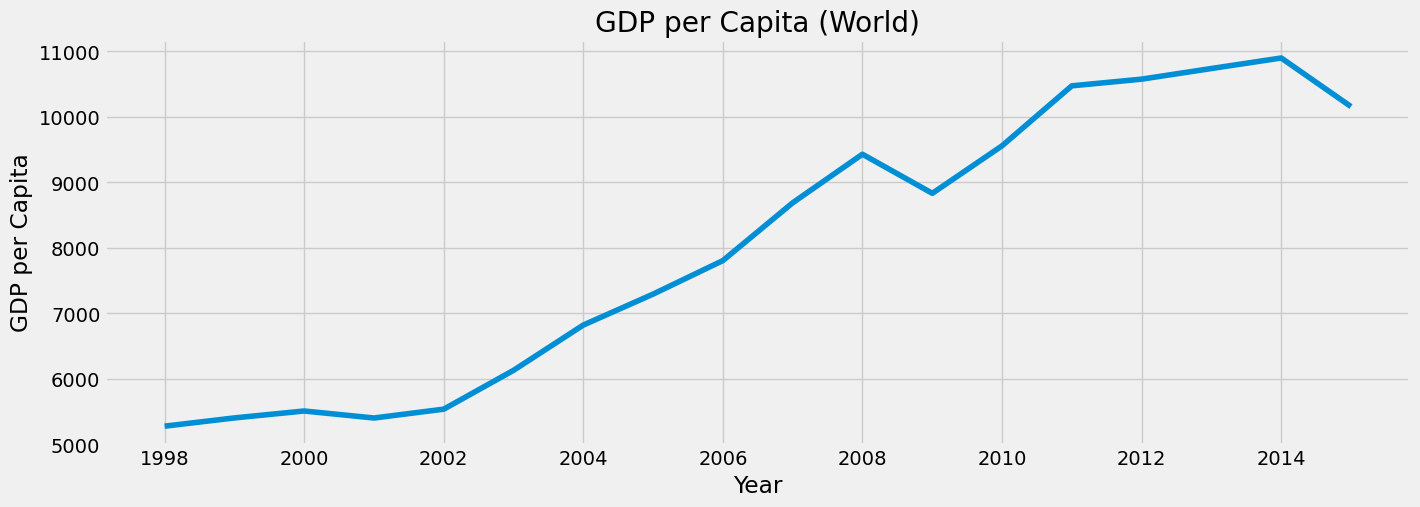

In [14]:
#plot World GDP data 

plt.figure(figsize = (15,5), dpi = 100)
plt.plot(data_plot_2)
plt.xlabel('Year')
plt.ylabel('GDP per Capita')
plt.title('GDP per Capita (World)')

### Data Cleaning and Subsetting

In [15]:
#check for missing values
data_plot_2.isnull().sum()

gdp_per_capita    0
dtype: int64

In [16]:
#check for duplicated values
data_plot_2.duplicated().sum()

0

The subset for the data has already been created. Becuase there are so many different variabels (energy sources and countries). I already created a subset that looks specifically at the GDP per Capita of the World

### Decomposition

In [19]:
#set fixed size for charts
rcParams['figure.figsize'] = 18, 7

In [20]:
data_plot_2.columns

Index(['gdp_per_capita'], dtype='object')

In [21]:
#decomposition - mulitiplicative
decomposition_multiplicative= sm.tsa.seasonal_decompose(data_plot_2, model='multiplicative')

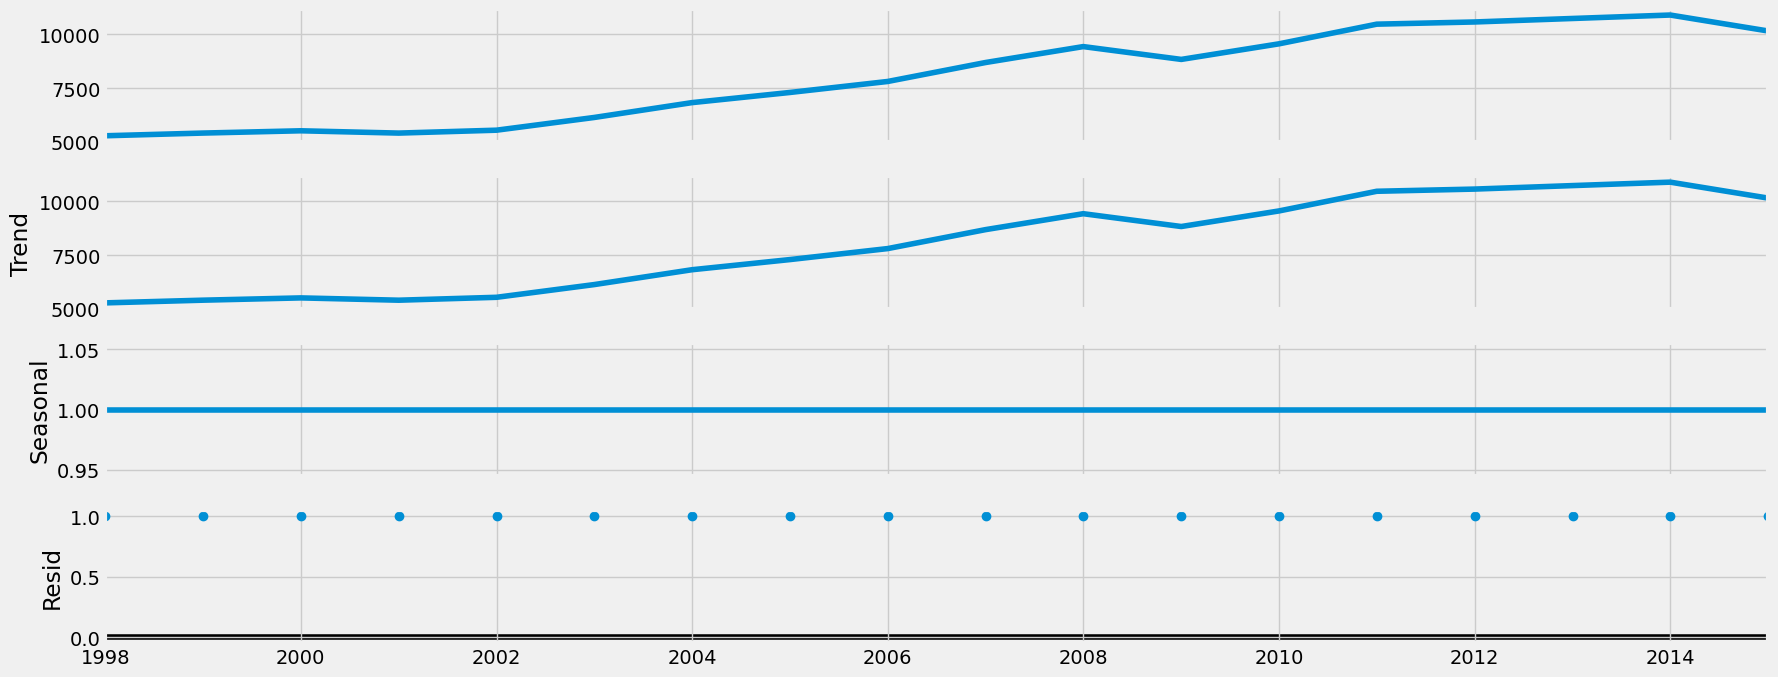

In [22]:
# Plot the separate components

decomposition_multiplicative.plot()
plt.show()

There is very little noise in this data, so the trend almost perfectly matches the acutal line of data.
The dominant trend is postive.
There is no seasonality in this data

### Testing for Stationarity

In [23]:
from statsmodels.tsa.stattools import adfuller

#create definition for the dickey fuller funtion
def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)


dickey_fuller(data_plot_2['gdp_per_capita'])

Dickey-Fuller Stationarity test:
Test Statistic                  0.081858
p-value                         0.964800
Number of Lags Used             7.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


Alt Hypothesis: there is not unit root
Null Hypothesis: there is a unit root

because the test statistic is larged that the 5% critical value, I cannont reject the null, which means that there is a unit root and differencing needs to be performed

### Differencing

In [24]:
data_diff = data_plot_2-data_plot_2.shift(1)

In [25]:
data_diff.dropna(inplace = True)

In [26]:
data_diff.head()

,gdp_per_capita
datetime,
1999-01-01,125.943713
2000-01-01,105.851081
2001-01-01,-107.030445
2002-01-01,135.112355
2003-01-01,592.583633


In [27]:
data_diff.columns

Index(['gdp_per_capita'], dtype='object')

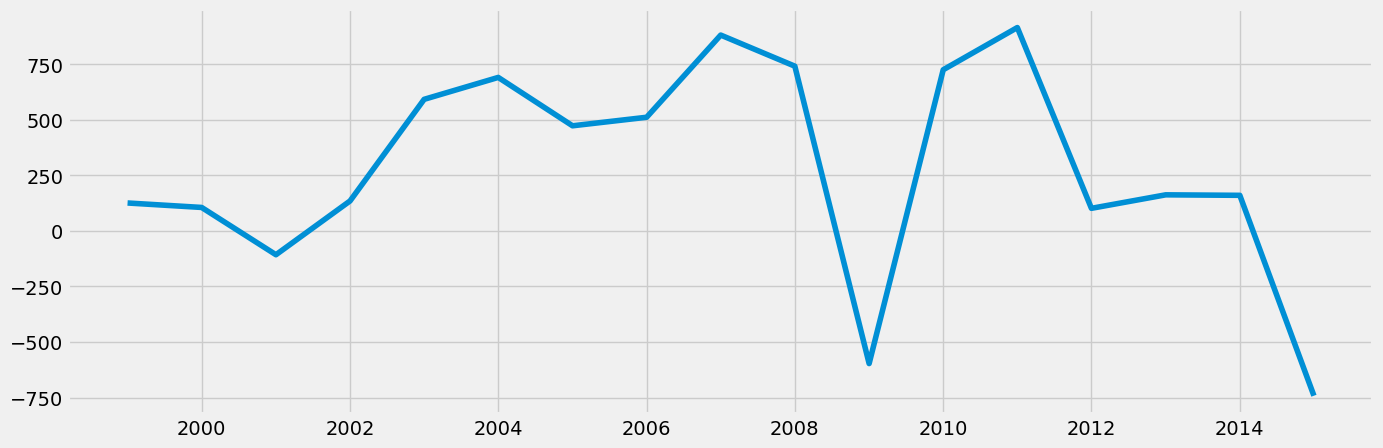

In [28]:
#plot differenced data
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [29]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.426077
p-value                         0.010101
Number of Lags Used             6.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


the test statistic is smaller than the 5% critical value so we can reject the null, and say that our data is stationary, we also have a p value < 0.05 making this data significant.

### Autocorrelations

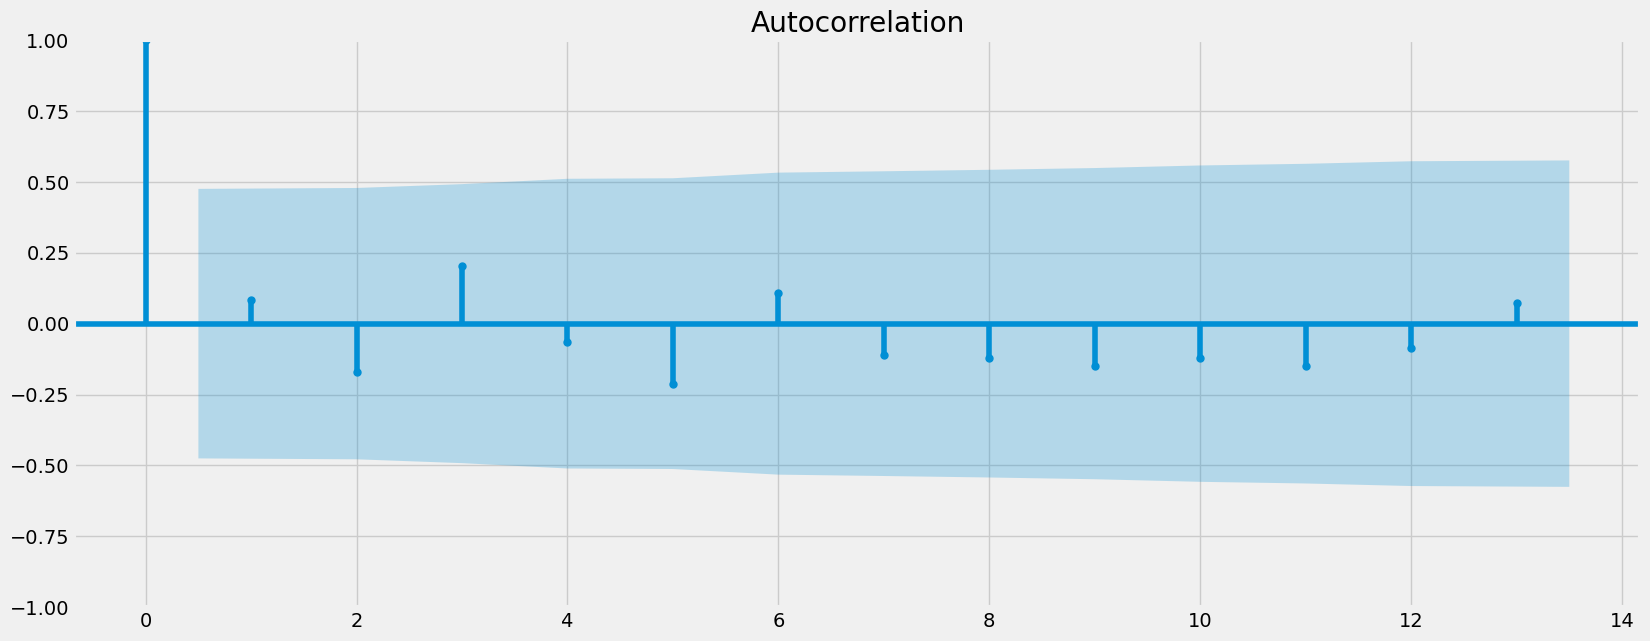

In [31]:
#plot auto correlation of differenced data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff)
plt.show()

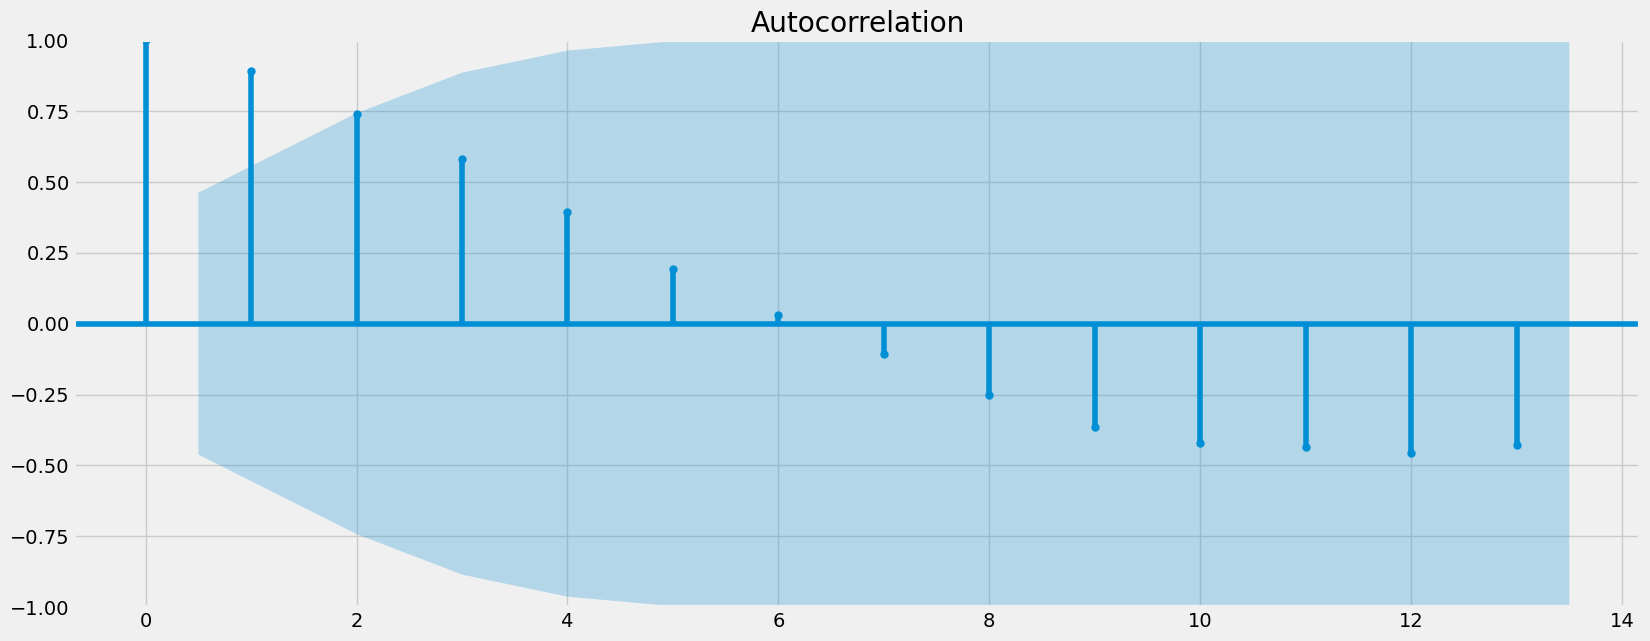

In [32]:
#plot autocorrelation of original data
plot_acf(data_plot_2)
plt.show()

Because the number of lags outside the confidence interval shaded area decreased once that data was decomposed and differenced, it suggests that the data is now stationary and something we can use to forecast with.